Generating transition list for skyline for a given molecule ID

In [1]:
# Generate a Skyline transition list **for a single row number** (e.g., 10)
# Ignores all other columns in the file.
#
# Expected columns in the CSV (case-insensitive; other columns are ignored):
#   - molecule
#   - matched_z_list
#   - matched_mz_list
#   - (optional) polarity / plolarity
#
# Output CSV columns (Skyline Small Molecule transition list):
#   Molecule, Precursor m/z, Precursor Adduct, Polarity
#
# Notes:
# - ROW_NUM is 1-based (ROW_NUM=10 means "the 10th row" in the file).
# - Charges of 0 are discarded. If polarity is missing/blank, defaults to Positive.

import re
from pathlib import Path
from typing import List, Optional
import pandas as pd

# ----------------------------
# EDIT THESE IF NEEDED
# ----------------------------
INPUT_PATH  = r"F:/20251005/input.csv"               # or "input.csv" or absolute path
OUTPUT_PATH = r"F:/20251005/transition_list_13352.csv"
ROW_NUM     = 1  # 1-based: e.g., 10 -> process only the 10th row
# ----------------------------

def extract_int_list(s) -> List[int]:
    if pd.isna(s):
        return []
    # Accept anything like: [2, 3, 4], "2,3,4", "z=2;3;4", etc.
    return [int(x) for x in re.findall(r"[-+]?\d+", str(s))]

def extract_float_list(s) -> List[float]:
    if pd.isna(s):
        return []
    # Accept 123, 123.4, .45, 1e3, -2.5E-2, etc.
    pattern = r"[-+]?(?:\d+\.\d*|\.\d+|\d+)(?:[eE][-+]?\d+)?"
    return [float(x) for x in re.findall(pattern, str(s))]

def norm_polarity(val) -> str:
    if val is None or str(val).strip().lower() in ("", "nan", "none"):
        return "Positive"
    return "Negative" if str(val).strip().lower().startswith("neg") else "Positive"

def adduct_from_charge(z: int, polarity: str = "Positive") -> str:
    # Skyline adduct notation from integer charge + polarity
    try:
        z = int(round(float(z)))
    except Exception:
        z = 1
    if z == 0:
        z = 1
    if str(polarity).lower().startswith("neg"):
        return f"[M-{abs(z)}H]{abs(z)}-"
    else:
        return f"[M+{abs(z)}H]{abs(z)}+"

def find_col(df: pd.DataFrame, candidates: List[str]) -> Optional[str]:
    # Case-insensitive lookup; returns the actual column name if found
    lower_map = {c.lower(): c for c in df.columns}
    for cand in candidates:
        c = cand.lower()
        if c in lower_map:
            return lower_map[c]
    return None

# --- Load CSV (ignore extra columns, we will only touch what we need) ---
p = Path(INPUT_PATH)
if not p.exists():
    raise FileNotFoundError(f"Input file not found: {INPUT_PATH}")

# Read all (cheapest is to read the file; we will ignore extra columns downstream)
df_full = pd.read_csv(p, low_memory=False)

# Validate row number (1-based)
if ROW_NUM < 1 or ROW_NUM > len(df_full):
    raise IndexError(f"ROW_NUM={ROW_NUM} is out of range (file has {len(df_full)} rows).")

# Pick only the single row requested
df = df_full.iloc[[ROW_NUM - 1]].copy()

# --- Identify required columns (case-insensitive) ---
molecule_col = find_col(df, ["molecule"])
zlist_col    = find_col(df, ["matched_z_list"])
mzlist_col   = find_col(df, ["matched_mz_list"])
pol_col      = find_col(df, ["polarity", "plolarity"])  # accept common misspelling

if not molecule_col or not zlist_col or not mzlist_col:
    raise ValueError(
        "Missing required columns. Need at least: 'molecule', 'matched_z_list', 'matched_mz_list'. "
        f"Found: {list(df.columns)}"
    )

# Force types we care about
df[molecule_col] = df[molecule_col].astype(str)

# --- Build transitions for the single row ---
rows, skipped = [], []
r = df.iloc[0]
mol = r[molecule_col]
pol = norm_polarity(r[pol_col] if pol_col in df.columns else None)
z_list  = extract_int_list(r[zlist_col])
mz_list = extract_float_list(r[mzlist_col])

n = min(len(z_list), len(mz_list))
if n == 0:
    skipped.append((ROW_NUM, mol, "empty or unparsable matched_z_list/matched_mz_list"))
else:
    for z, mz in zip(z_list[:n], mz_list[:n]):
        try:
            z_int = int(z)
        except Exception:
            skipped.append((ROW_NUM, mol, f"non-integer charge '{z}' discarded"))
            continue
        if z_int == 0:
            skipped.append((ROW_NUM, mol, "charge=0 discarded"))
            continue
        rows.append({
            "Molecule": mol,
            "Precursor m/z": f"{float(mz):.6f}",
            "Precursor Adduct": adduct_from_charge(z_int, pol),
            "Polarity": pol
        })

transitions = pd.DataFrame(rows).drop_duplicates().reset_index(drop=True)

# --- Save CSV for Skyline ---
out_path = Path(OUTPUT_PATH)
out_path.parent.mkdir(parents=True, exist_ok=True)

# Ensure correct column order even if empty
wanted_cols = ["Molecule", "Precursor m/z", "Precursor Adduct", "Polarity"]
for c in wanted_cols:
    if c not in transitions.columns:
        transitions[c] = []
transitions = transitions[wanted_cols]

transitions.to_csv(out_path, index=False)

# --- Minimal console feedback ---
print(f"Processed only row #{ROW_NUM} from: {p.resolve()}")
print(f"Generated transitions: {len(transitions)}")
if skipped:
    print("Skipped entries (up to 10 shown):")
    for tup in skipped[:10]:
        print("  Row:", tup[0], "| Molecule:", tup[1], "| Reason:", tup[2])
print("Saved →", out_path.resolve())


Processed only row #1 from: F:\20251005\input.csv
Generated transitions: 16
Saved → F:\20251005\transition_list_13352.csv


Generating transition lists for all the molecules

In [2]:
# Generate Skyline transition lists for ALL rows
# One output CSV per row, with molecule name in the filename.
#
# Expected input columns (case-insensitive; others ignored):
#   - molecule
#   - matched_z_list
#   - matched_mz_list
#   - (optional) polarity / plolarity
#
# Output CSV columns (Skyline Small Molecule transition list):
#   Molecule, Precursor m/z, Precursor Adduct, Polarity

import re
import string
from pathlib import Path
from typing import List, Optional
import pandas as pd

# ----------------------------
# EDIT THESE IF NEEDED
# ----------------------------
INPUT_PATH = r"F:/binary/final/report.csv"      # path to your input CSV
OUTPUT_DIR = r"F:/binary/final"      # folder where per-molecule CSVs will be saved
FILENAME_PREFIX = "transition_list"        # prefix for each file name
# ----------------------------

def extract_int_list(s) -> List[int]:
    if pd.isna(s):
        return []
    # Accept anything like: [2, 3, 4], "2,3,4", "z=2;3;4", etc.
    return [int(x) for x in re.findall(r"[-+]?\d+", str(s))]

def extract_float_list(s) -> List[float]:
    if pd.isna(s):
        return []
    # Accept 123, 123.4, .45, 1e3, -2.5E-2, etc.
    pattern = r"[-+]?(?:\d+\.\d*|\.\d+|\d+)(?:[eE][-+]?\d+)?"
    return [float(x) for x in re.findall(pattern, str(s))]

def norm_polarity(val) -> str:
    if val is None or str(val).strip().lower() in ("", "nan", "none"):
        return "Positive"
    return "Negative" if str(val).strip().lower().startswith("neg") else "Positive"

def adduct_from_charge(z: int, polarity: str = "Positive") -> str:
    # Skyline adduct notation from integer charge + polarity
    try:
        z = int(round(float(z)))
    except Exception:
        z = 1
    if z == 0:
        z = 1
    if str(polarity).lower().startswith("neg"):
        return f"[M-{abs(z)}H]{abs(z)}-"
    else:
        return f"[M+{abs(z)}H]{abs(z)}+"

def find_col(df: pd.DataFrame, candidates: List[str]) -> Optional[str]:
    # Case-insensitive lookup; returns the actual column name if found
    lower_map = {c.lower(): c for c in df.columns}
    for cand in candidates:
        c = cand.lower()
        if c in lower_map:
            return lower_map[c]
    return None

def safe_slug(text: str, max_len: int = 80) -> str:
    """Make a filesystem-safe slug from molecule name."""
    if text is None:
        text = "unknown"
    text = str(text).strip()
    # Replace spaces with underscores, drop disallowed chars
    allowed = f"-_.() {string.ascii_letters}{string.digits}"
    cleaned = "".join(ch if ch in allowed else "_" for ch in text)
    cleaned = "_".join(cleaned.split())  # collapse whitespace runs
    if not cleaned:
        cleaned = "unknown"
    return cleaned[:max_len]

def unique_path(base_path: Path) -> Path:
    """Return a unique path by appending -1, -2, ... if needed."""
    if not base_path.exists():
        return base_path
    stem, suffix = base_path.stem, base_path.suffix
    i = 1
    while True:
        candidate = base_path.with_name(f"{stem}-{i}{suffix}")
        if not candidate.exists():
            return candidate
        i += 1

# --- Load CSV ---
p = Path(INPUT_PATH)
if not p.exists():
    raise FileNotFoundError(f"Input file not found: {INPUT_PATH}")

df_full = pd.read_csv(p, low_memory=False)

# --- Identify required columns (case-insensitive) ---
molecule_col = find_col(df_full, ["molecule"])
zlist_col    = find_col(df_full, ["matched_z_list"])
mzlist_col   = find_col(df_full, ["matched_mz_list"])
pol_col      = find_col(df_full, ["polarity", "plolarity"])  # accept common misspelling

if not molecule_col or not zlist_col or not mzlist_col:
    raise ValueError(
        "Missing required columns. Need at least: 'molecule', 'matched_z_list', 'matched_mz_list'. "
        f"Found: {list(df_full.columns)}"
    )

# Force types we care about
df_full[molecule_col] = df_full[molecule_col].astype(str)

# Prepare output dir
out_dir = Path(OUTPUT_DIR)
out_dir.mkdir(parents=True, exist_ok=True)

wanted_cols = ["Molecule", "Precursor m/z", "Precursor Adduct", "Polarity"]

total_rows = len(df_full)
total_transitions = 0
skipped_overall = []

for idx0, r in df_full.iterrows():
    row_num = idx0 + 1  # 1-based for user-facing messages
    mol = r[molecule_col]
    pol = norm_polarity(r[pol_col] if pol_col in df_full.columns else None)
    z_list  = extract_int_list(r[zlist_col])
    mz_list = extract_float_list(r[mzlist_col])

    rows = []
    n = min(len(z_list), len(mz_list))
    if n == 0:
        skipped_overall.append((row_num, mol, "empty or unparsable matched_z_list/matched_mz_list"))
    else:
        for z, mz in zip(z_list[:n], mz_list[:n]):
            try:
                z_int = int(z)
            except Exception:
                skipped_overall.append((row_num, mol, f"non-integer charge '{z}' discarded"))
                continue
            if z_int == 0:
                skipped_overall.append((row_num, mol, "charge=0 discarded"))
                continue
            rows.append({
                "Molecule": mol,
                "Precursor m/z": f"{float(mz):.6f}",
                "Precursor Adduct": adduct_from_charge(z_int, pol),
                "Polarity": pol
            })

    transitions = pd.DataFrame(rows).drop_duplicates().reset_index(drop=True)
    # ensure column order even if empty
    for c in wanted_cols:
        if c not in transitions.columns:
            transitions[c] = []
    transitions = transitions[wanted_cols]

    # Build output filename with molecule name and row number
    mol_slug = safe_slug(mol)
    fname = f"{FILENAME_PREFIX}_{row_num:05d}_{mol_slug}.csv"
    out_path = unique_path(out_dir / fname)

    transitions.to_csv(out_path, index=False)
    total_transitions += len(transitions)

    print(f"[Row {row_num}/{total_rows}] {mol} -> {len(transitions)} transitions | Saved: {out_path.name}")

print(f"\nAll done. Total transitions across {total_rows} rows: {total_transitions}")
if skipped_overall:
    print("Skipped entries (up to 20 shown):")
    for tup in skipped_overall[:20]:
        print("  Row:", tup[0], "| Molecule:", tup[1], "| Reason:", tup[2])
print(f"Output folder → {Path(OUTPUT_DIR).resolve()}")


[Row 1/170] ASYN:12870 -> 9 transitions | Saved: transition_list_00001_ASYN_12870.csv
[Row 2/170] ASYN:19150 -> 16 transitions | Saved: transition_list_00002_ASYN_19150.csv
[Row 3/170] ASYN:19960 -> 13 transitions | Saved: transition_list_00003_ASYN_19960.csv
[Row 4/170] nASYN:10360 -> 11 transitions | Saved: transition_list_00004_nASYN_10360.csv
[Row 5/170] nASYN:10390 -> 8 transitions | Saved: transition_list_00005_nASYN_10390.csv
[Row 6/170] nASYN:11750 -> 12 transitions | Saved: transition_list_00006_nASYN_11750.csv
[Row 7/170] nASYN:11760 -> 12 transitions | Saved: transition_list_00007_nASYN_11760.csv
[Row 8/170] nASYN:12280 -> 13 transitions | Saved: transition_list_00008_nASYN_12280.csv
[Row 9/170] nASYN:12610 -> 10 transitions | Saved: transition_list_00009_nASYN_12610.csv
[Row 10/170] nASYN:13430 -> 14 transitions | Saved: transition_list_00010_nASYN_13430.csv
[Row 11/170] nASYN:13450 -> 14 transitions | Saved: transition_list_00011_nASYN_13450.csv
[Row 12/170] nASYN:13480 ->

plotting smooth XICs

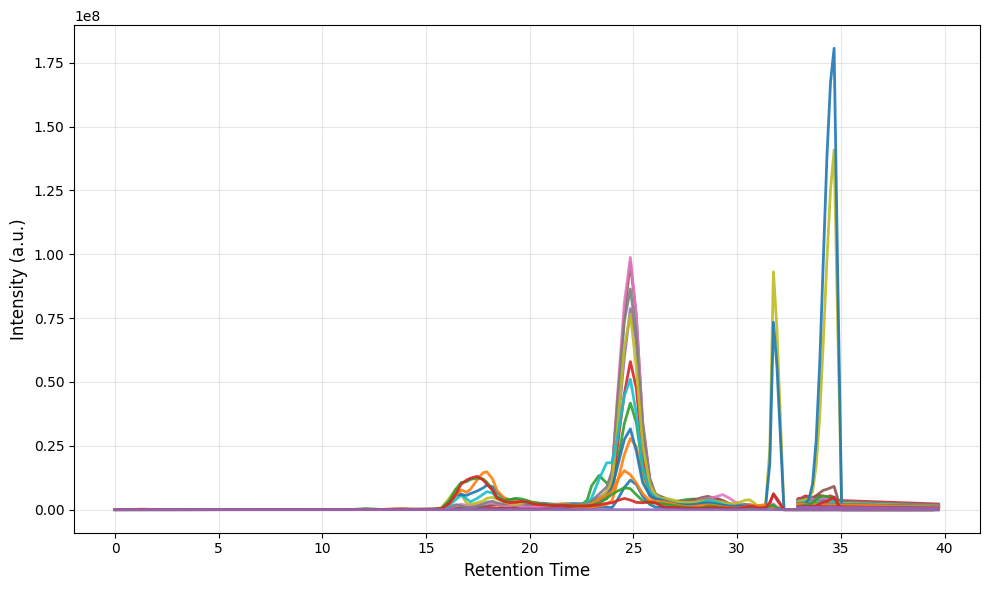

✅ Plot saved to: F:\Book1_no_legend.png


In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from pathlib import Path

# ---------------- CONFIG ----------------
INPUT_FILE = r"F:/13970.xlsx"   # your Excel file
SHEET_NAME = 0
SMOOTH_WINDOW = 2
POLY_ORDER = 1
OUT_PNG = Path(INPUT_FILE).with_name("Book1_no_legend.png")
# ----------------------------------------

# Load and clean data
df = pd.read_excel(INPUT_FILE, sheet_name=SHEET_NAME).dropna(how="all")
df = df.apply(pd.to_numeric, errors="coerce")
df = df.dropna(how="all")

x = df.iloc[:, 0].values
intensity_cols = df.columns[1:]

plt.figure(figsize=(10, 6))
#plt.title("Smoothed Intensity vs Retention Time", fontsize=14)
plt.xlabel("Retention Time", fontsize=12)
plt.ylabel("Intensity (a.u.)", fontsize=12)

for col in intensity_cols:
    y = df[col].values
    if len(y) < SMOOTH_WINDOW:
        smooth_y = y
    else:
        smooth_y = savgol_filter(y, SMOOTH_WINDOW, POLY_ORDER)
    plt.plot(x, smooth_y, linewidth=2, alpha=0.9)

plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig(OUT_PNG, dpi=300)
#plt.xlim((30,50))
plt.show()

print(f"✅ Plot saved to: {OUT_PNG}")


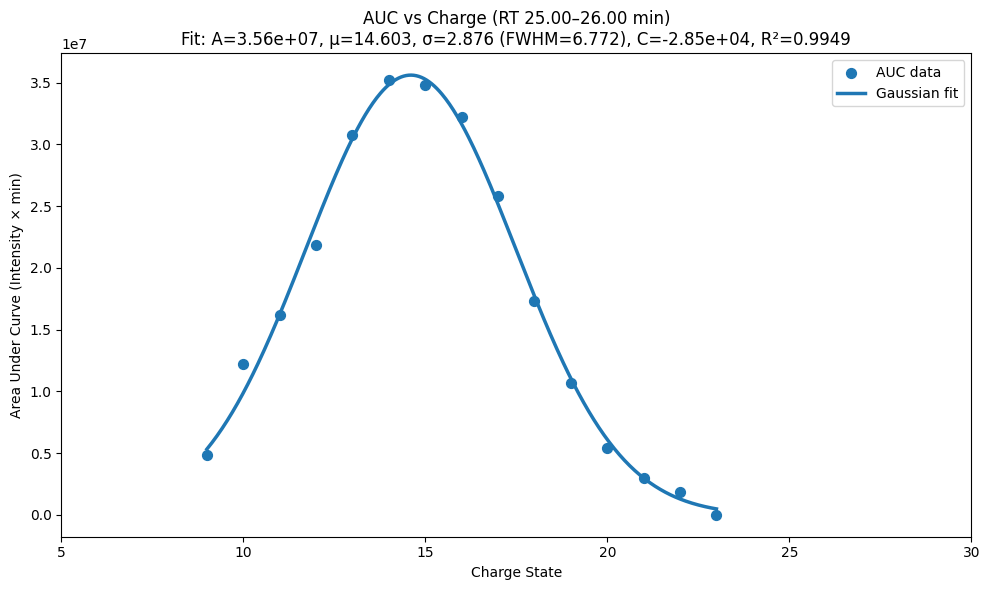

Gaussian params: A=3.5645e+07, mu=14.602857, sigma=2.875731, C=-28525.1, R^2=0.99494, FWHM=6.771828
Saved AUC table: F:\binary\final\auc_by_charge_20_25.csv
Saved plot (scatter + Gaussian): F:\binary\final\charge_envelope_gaussian_over_data.png


In [22]:
# AUC (RT window) by charge state + Gaussian fit OVER SCATTERED DATA — single notebook cell
# - Computes AUC per charge in the given RT window
# - Fits a Gaussian to (charge -> AUC)
# - Plots the data points (scatter) and overlays the Gaussian curve on top

import re
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ========= CONFIG =========
FILE_PATH   = Path(r"F:/13970.xlsx")   # <- change if needed
SHEET_NAME  = 0                                    # sheet index or name
RT_WINDOW   = (25.0, 26.0)                         # minutes (min_inclusive, max_inclusive)
OUT_DIR     = Path(r"F:/binary/final")             # <- change if needed
OUT_DIR.mkdir(parents=True, exist_ok=True)
OUT_CSV     = OUT_DIR / "auc_by_charge_20_25.csv"
OUT_PNG     = OUT_DIR / "charge_envelope_gaussian_over_data.png"
# ==========================

# --- Load Excel ---
df = pd.read_excel(FILE_PATH, sheet_name=SHEET_NAME)

# If first row holds descriptors (Retention Time / Intensity), drop it
if (
    len(df.columns) > 0
    and str(df.columns[0]).lower().startswith("unnamed")
    and isinstance(df.iloc[0, 0], str)
    and "retention" in df.iloc[0, 0].lower()
):
    df = df.iloc[1:].reset_index(drop=True)

# Standardize RT column name
df = df.rename(columns={df.columns[0]: "rt_min"})

# Coerce numerics
df["rt_min"] = pd.to_numeric(df["rt_min"], errors="coerce")
for c in df.columns[1:]:
    df[c] = pd.to_numeric(df[c], errors="coerce")

# Slice RT window
rt_lo, rt_hi = RT_WINDOW
win = df[(df["rt_min"] >= rt_lo) & (df["rt_min"] <= rt_hi)].copy()

# Map columns -> charge states (e.g., "...+17H]")
charge_by_col = {}
for c in df.columns[1:]:
    m = re.search(r"\+(\d+)H", str(c))
    if m:
        charge_by_col[c] = int(m.group(1))

# Compute AUC per charge (trapezoid rule)
rows = []
for col, z in sorted(charge_by_col.items(), key=lambda kv: kv[1]):
    g = win[["rt_min", col]].dropna()
    if len(g) >= 2:
        g = g.sort_values("rt_min")
        auc = float(np.trapz(g[col].to_numpy(), g["rt_min"].to_numpy()))
    else:
        auc = 0.0
    rows.append({"charge": z, "auc_20_25": auc, "n_points": int(len(g))})

auc_df = pd.DataFrame(rows).sort_values("charge").reset_index(drop=True)
auc_df.to_csv(OUT_CSV, index=False)

# --------------------------
#     GAUSSIAN FIT
# --------------------------
def gaussian(z, A, mu, sigma, C):
    return A * np.exp(-((z - mu) ** 2) / (2.0 * sigma ** 2)) + C

z = auc_df["charge"].to_numpy(dtype=float)
y = auc_df["auc_20_25"].to_numpy(dtype=float)
mask = np.isfinite(z) & np.isfinite(y) & (y >= 0)
z_fit = z[mask]
y_fit = y[mask]

if len(z_fit) >= 3 and np.nanmax(y_fit) > 0:
    # Initial guesses
    C0   = float(np.min(y_fit))
    A0   = float(np.max(y_fit) - C0)
    mu0  = float(np.sum(z_fit * y_fit) / (np.sum(y_fit) + 1e-12))  # weighted mean
    sigma0 = float(np.sqrt(np.sum(y_fit * (z_fit - mu0) ** 2) / (np.sum(y_fit) + 1e-12)))
    sigma0 = sigma0 if sigma0 > 0 else max(1.0, (np.max(z_fit) - np.min(z_fit)) / 6.0)

    try:
        from scipy.optimize import curve_fit
        popt, pcov = curve_fit(
            gaussian,
            z_fit, y_fit,
            p0=[A0, mu0, sigma0, C0],
            bounds=([0, np.min(z_fit)-5, 1e-6, -np.inf],
                    [np.inf, np.max(z_fit)+5, np.inf,  np.inf]),
            maxfev=20000
        )
        A, mu, sigma, C = popt
    except Exception:
        # Fallback (no SciPy): fit quadratic to ln(y) assuming C≈0
        C = 0.0
        y_pos = np.maximum(y_fit, 1e-12)
        a, b, c = np.polyfit(z_fit, np.log(y_pos), 2)
        if a < 0:
            mu = -b / (2 * a)
            sigma = np.sqrt(-1 / (2 * a))
            A = np.exp(c - (mu ** 2) * a - b * mu)
        else:
            mu, sigma, A = mu0, sigma0, A0

    # Grid + metrics
    z_grid = np.linspace(np.min(z_fit), np.max(z_fit), 400)
    y_grid = gaussian(z_grid, A, mu, sigma, C)
    y_hat  = gaussian(z_fit, A, mu, sigma, C)
    ss_res = float(np.sum((y_fit - y_hat) ** 2))
    ss_tot = float(np.sum((y_fit - np.mean(y_fit)) ** 2)) + 1e-12
    r2     = 1.0 - ss_res / ss_tot
    fwhm   = 2.354820045 * sigma

    # ---- PLOT: scatter data with Gaussian on top ----
    plt.figure(figsize=(10, 6))
    plt.scatter(z, y, s=50, label="AUC data")   # data points
    plt.plot(z_grid, y_grid, linewidth=2.5, label="Gaussian fit")  # overlayed fit
    plt.title(
        f"AUC vs Charge (RT {rt_lo:.2f}–{rt_hi:.2f} min)\n"
        f"Fit: A={A:,.3g}, μ={mu:,.3f}, σ={sigma:,.3f} (FWHM={fwhm:,.3f}), C={C:,.3g}, R²={r2:.4f}"
    )
    plt.xlabel("Charge State")
    plt.ylabel("Area Under Curve (Intensity × min)")
    plt.xlim((5,30))
    plt.legend()
    plt.tight_layout()
    plt.savefig(OUT_PNG, dpi=150)
    plt.show()

    print(f"Gaussian params: A={A:.6g}, mu={mu:.6f}, sigma={sigma:.6f}, C={C:.6g}, R^2={r2:.5f}, FWHM={fwhm:.6f}")
else:
    print("Not enough valid points to fit a Gaussian (need ≥3 finite AUC values).")

print(f"Saved AUC table: {OUT_CSV.resolve()}")
print(f"Saved plot (scatter + Gaussian): {OUT_PNG.resolve()}")
